In [8]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import matplotlib as mpl
import math

In [9]:
result_path_1 = '../results/Ach-ver16'
sub_path_1 = 'voxel-integration-region-SRD-long-formal'
result_path_2 = '../results/Ach-ver16'
sub_path_2 = 'each_region_L-DEEPCAD-formal'
filename = 'accuracy' # accuracy / accuracy_svm / AUC_weighted / f1_weighted
if_save = False

fly_selected = [0,1,2,3,5,6,7,8,9] # 5ht-no 7; ach-no 4;0-9
num_fly = len(fly_selected)
thresh = np.arange(0,1,0.02)

figure_save_path = result_path_1 + '/' + 'figures-for-ver16-final6'
folder = os.path.exists(figure_save_path)
if not folder:
    os.makedirs(figure_save_path)

dim_thresh = 25
expr_thresh = 0.8

br_name = np.array(['All','MBPED_L','MBVL_L','MBML_L','LH_L','SLP_L','SIP_L','SMP_L','CRE_L','EB'])
br_olf = [0,1,1,1,1,1,1,1,1,0]

In [10]:
# read voxel
file_folders = os.listdir(result_path_1)
print(file_folders)
data_1 = []
num_dim = []
for i in range(num_fly):
    # load data
    the_path = result_path_1 + '/' + file_folders[fly_selected[i]] + '/' + sub_path_1 + '/' + 'list_list_' + filename + '.npy'
    folder = os.path.exists(the_path)
    if not folder:
        continue
    a = np.load(the_path)
    a = np.squeeze(a)
    if np.size(a,1) == 5:
        a = np.squeeze(a[:,2,:,:,:])
    data_1.append(a)
    # load num_dim
    the_path = result_path_1 + '/' + file_folders[fly_selected[i]] + '/' + sub_path_1 + '/' + 'list_list_num_dim.npy'
    folder = os.path.exists(the_path)
    if not folder:
        continue
    a = np.load(the_path)
    a = np.squeeze(a)
    if np.size(a,1) == 5:
        a = np.squeeze(a[:,2,:,:])
    num_dim.append(a)
data_1 = np.array(data_1)
print(np.shape(data_1))
num_dim = np.array(num_dim)
print(np.shape(num_dim))

['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', '20230507-fly1', '20230510-fly1', '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1', 'DEEPCAD', 'figures', 'figures-for-ver16-final6']
(9, 3, 50, 5, 2)
(9, 3, 50, 2)


In [11]:
# read each region
data_2 = []
for i in range(num_fly):
    the_path = result_path_2 + '/' + file_folders[fly_selected[i]] + '/' + sub_path_2 + '/' + 'list_' + filename + '_each_region.npy'
    folder = os.path.exists(the_path)
    if not folder:
        continue
    a = np.load(the_path)
    a = np.squeeze(a)
    data_2.append(a)
data_2 = np.array(data_2)
np.shape(data_2)

(9, 3, 9, 50, 5, 2)

In [12]:
# voxel threshold
max_data_1 = np.zeros((num_fly,np.size(data_1,1),np.size(data_1,4)))
for i in range(num_fly):
    for j in range(np.size(data_1,1)):
        for k in range(np.size(data_1,4)):
            flag = 0
            for m in range(np.size(data_1,2)):
                if num_dim[i,j,m,k]>=dim_thresh:
                    flag = m
                    break
            a = data_1[i,j,int(flag),:,k]
            max_data_1[i,j,k] = np.mean(a)
np.shape(max_data_1)

(9, 3, 2)

In [13]:
# each region threshold
max_data_2 = np.mean(data_2,4)
max_data_2 = np.squeeze(max_data_2[:,:,:,thresh==expr_thresh,:])
np.shape(max_data_2)

(9, 3, 9, 2)

(9, 1)
(9, 9)
(9, 10)


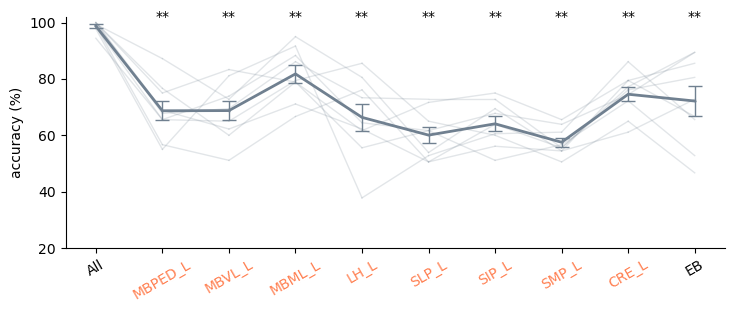

(9, 1)
(9, 9)
(9, 10)


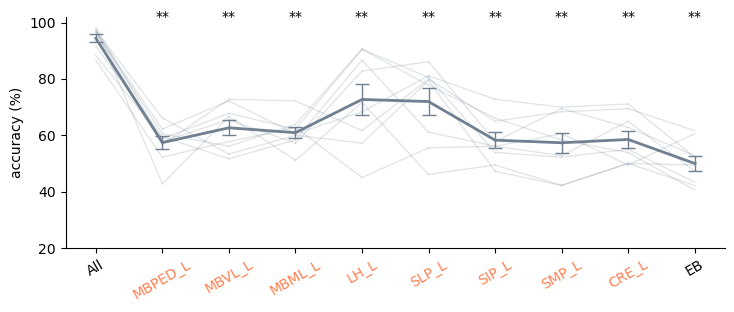

(9, 1)
(9, 9)
(9, 10)


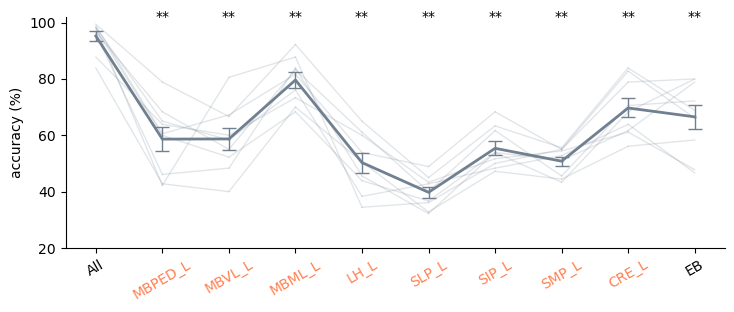

In [14]:
ymin = [20,20,20]
# only compare 1 channel
for i in range(np.size(max_data_2,1)):
    a = max_data_1[:,i,0]
    b = max_data_2[:,i,:,0]
    a = a[:,np.newaxis]
    print(np.shape(a))
    print(np.shape(b))

    data_save = np.concatenate((a,b),axis = 1)
    print(np.shape(data_save))
    data_save = data_save*100

    the_mean = np.zeros(np.size(data_save,1))
    the_std = np.zeros(np.size(data_save,1))
    for j in range(np.size(data_save,1)):
        aa = np.squeeze(data_save[:,j])
        the_mean[j] = np.mean(aa[aa!=0])
        the_std[j] = np.std(aa[aa!=0],ddof = 1)/math.sqrt(len(aa[aa!=0])) 
    # plot
    num_fly = np.size(data_save,0)
    color_list = plt.cm.tab10(np.linspace(0,1,num_fly))
    plt.figure(figsize = (8.5,3))
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.errorbar(range(np.size(data_save,1)),the_mean,yerr=the_std,ecolor='slategray',elinewidth=1,marker='.',mfc='slategray',\
	mec='slategray',mew=1,ms=1,alpha=1,capsize=5,capthick=3,color='slategray', linewidth=2)     
    for k in range(num_fly):
        for j in range(len(br_name)-1):
            if data_save[k,j]!=0 and data_save[k,j+1]!=0:
                plt.plot([j,j+1],[data_save[k,j],data_save[k,j+1]],color='slategray', linewidth=1,alpha = 0.2)
    plt.ylim((ymin[i],102))
    plt.xticks(np.linspace(0,len(br_name)-1,len(br_name)),br_name,rotation=30)
    for j in range(len(br_name)):
        if br_olf[j]==1:
            plt.gca().get_xticklabels()[j].set_color('coral') 
    plt.ylabel(filename + ' (%)')
    # wilcoxon test
    for j in range(1,len(br_name)):
        a = data_save[:,0]
        b = data_save[:,j]
        a = a[b!=0]
        b = b[b!=0]
        res = wilcoxon(a,b)
        p = res.pvalue
        if p<0.05 and p>=0.01:
            plt.text(j,102,'*',verticalalignment = 'center', horizontalalignment = 'center')
        elif p<0.01 and p>0.001:
            plt.text(j,102,'**',verticalalignment = 'center', horizontalalignment = 'center')
        elif p<0.001 and p>=0.0001:
            plt.text(j,102,'***',verticalalignment = 'center', horizontalalignment = 'center') 
        elif p<0.0001:
            plt.text(j,102,'****',verticalalignment = 'center', horizontalalignment = 'center') 
    if if_save:
        mpl.rcParams['pdf.fonttype'] = 42
        mpl.rcParams['ps.fonttype'] = 42
        plt.savefig(figure_save_path + '/' + '2H_'+ filename +'_multiple_region_over_single_c'+str(i)+'-hor.pdf',dpi = 300,bbox_inches = 'tight')
        plt.savefig(figure_save_path + '/' + '2H_'+ filename +'_multiple_region_over_single_c'+str(i)+'-hor.png',dpi = 300,bbox_inches = 'tight')
    plt.show()